# QoSBuddy

## 1-Data Acquisition and Understanding: 

Starting with loading and exploring the chosen dataset from Zenodo. This dataset provides QoS metrics from 5G campus networks, including one-way delay, throughput, jitter, and packet loss, which align with our project's goals for network performance monitoring and anomaly detection.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings 

%matplotlib inline
sns.set_theme(style="darkgrid")

Since the dataset 'ntnu_owd_all_Packets.csv' is large (approximately 2.7 GB) and contains packet-level data from 5G network measurements, we'll load a sample of the first 100,000 rows for initial exploration to avoid memory issues. This allows us to inspect the structure, columns, and data types.

In [2]:
# Define the file path 
file_path = "../ntnu_owd_all_Packets.csv"


# Load sample with proper handling for mixed-type IP columns
df_sample = pd.read_csv(
    file_path, 
    nrows=100000,
    dtype={'SourceIPOuter': 'string', 'DestinationIPOuter': 'string'},
    low_memory=False
)

print("Shape:", df_sample.shape)
df_sample.head()

Shape: (100000, 23)


,Unnamed: 0,src,Timestamp,SourceIPOuter,DestinationIPOuter,SourceIPInner,DestinationIPInner,PacketSize,SeqNum,iat,...,bw,slots,ratio,pdist,piat,psize,pnpak,rep,scenario,direction
0,1,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,1,0.000000,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink
1,2,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,2,0.001712,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink
2,3,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,3,0.001652,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink
3,4,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,4,0.001694,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink
4,5,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,5,0.001704,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink


Now that the data is loaded, let's inspect its structure. This includes checking data types, non-null counts, and memory usage with .info(). We'll also list the columns for reference. This helps identify if any columns need type conversion (e.g., 'Timestamp' to datetime) or if there are missing values.

In [3]:
# Get data info
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          100000 non-null  int64  
 1   src                 100000 non-null  object 
 2   Timestamp           100000 non-null  float64
 3   SourceIPOuter       40000 non-null   string 
 4   DestinationIPOuter  40000 non-null   string 
 5   SourceIPInner       100000 non-null  object 
 6   DestinationIPInner  100000 non-null  object 
 7   PacketSize          100000 non-null  int64  
 8   SeqNum              100000 non-null  int64  
 9   iat                 100000 non-null  float64
 10  trel                100000 non-null  float64
 11  gnb                 100000 non-null  object 
 12  sdr                 100000 non-null  object 
 13  bw                  100000 non-null  int64  
 14  slots               100000 non-null  int64  
 15  ratio               100000 non-null

We first explore numerical columns: 

In [4]:
# Statistical summary of numerical columns
numerical_summary = df_sample.describe()
print("Numerical Features Summary:")
print(numerical_summary.round(2))

Numerical Features Summary:
       Unnamed: 0     Timestamp  PacketSize     SeqNum        iat       trel  \
count   100000.00  1.000000e+05   100000.00  100000.00  100000.00  100000.00   
mean     50000.50  1.720190e+09       58.09    5000.50       0.00       8.51   
std      28867.66  1.302620e+03       28.42    2886.77       0.00       4.91   
min          1.00  1.720189e+09       32.00       1.00      -0.00       0.00   
25%      25000.75  1.720189e+09       35.00    2500.75       0.00       4.25   
50%      50000.50  1.720191e+09       35.00    5000.50       0.00       8.51   
75%      75000.25  1.720191e+09       93.00    7500.25       0.00      12.76   
max     100000.00  1.720191e+09       94.00   10000.00       0.01      17.02   

             bw     slots     ratio      piat     pnpak        rep  
count  100000.0  100000.0  100000.0  100000.0  100000.0  100000.00  
mean       20.0      10.0       2.0    1700.0   10000.0       1.80  
std         0.0       0.0       0.0       0.

We explore the categorical features: 

In [5]:
# Identify categorical columns
categorical_cols = df_sample.select_dtypes(include=['object', 'string']).columns.tolist()

print(f"Categorical Features ({len(categorical_cols)} columns):\n")

# Display unique value counts for each categorical column
for col in categorical_cols:
    unique_count = df_sample[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 10:  # Show value counts for columns with few unique values
        print(df_sample[col].value_counts())
    print("-" * 60)

Categorical Features (11 columns):

src: 2 unique values
src
1ue     60000
2gnb    40000
Name: count, dtype: int64
------------------------------------------------------------
SourceIPOuter: 2 unique values
SourceIPOuter
11.10.0.2    20000
11.10.0.1    20000
Name: count, dtype: Int64
------------------------------------------------------------
DestinationIPOuter: 2 unique values
DestinationIPOuter
11.10.0.1    20000
11.10.0.2    20000
Name: count, dtype: Int64
------------------------------------------------------------
SourceIPInner: 2 unique values
SourceIPInner
10.45.0.2    50000
10.45.0.1    50000
Name: count, dtype: int64
------------------------------------------------------------
DestinationIPInner: 2 unique values
DestinationIPInner
10.45.0.1    50000
10.45.0.2    50000
Name: count, dtype: int64
------------------------------------------------------------
gnb: 1 unique values
gnb
oai    100000
Name: count, dtype: int64
-----------------------------------------------------------

In [6]:
# Analyze the experimental setup and data collection parameters
print("=" * 80)
print("DATA COLLECTION CONTEXT")
print("=" * 80)

# Network configuration parameters (from the fixed columns)
print("\nNetwork Configuration:")
print(f"  Bandwidth: {df_sample['bw'].unique()[0]} MHz")
print(f"  Time Slots: {df_sample['slots'].unique()[0]}")
print(f"  Slot Ratio: {df_sample['ratio'].unique()[0]}")
print(f"  Packet IAT: {df_sample['piat'].unique()[0]} µs")
print(f"  Packets per Rep: {df_sample['pnpak'].unique()[0]}")

# Experimental setup
print("\nExperimental Setup:")
print(f"  gNB Type: {df_sample['gnb'].unique()[0]}")
print(f"  SDR Hardware: {df_sample['sdr'].unique()[0]}")
print(f"  Packet Distribution: {df_sample['pdist'].unique()[0]}")
print(f"  Packet Size Profile: {df_sample['psize'].unique()[0]}")

# Repetitions and scenarios
print(f"\nRepetitions: {sorted(df_sample['rep'].unique())}")
print(f"Traffic Directions: {df_sample['direction'].unique().tolist()}")
print(f"Source Types: {df_sample['src'].unique().tolist()}")

DATA COLLECTION CONTEXT

Network Configuration:
  Bandwidth: 20 MHz
  Time Slots: 10
  Slot Ratio: 2
  Packet IAT: 1700 µs
  Packets per Rep: 10000

Experimental Setup:
  gNB Type: oai
  SDR Hardware: b200
  Packet Distribution: det
  Packet Size Profile: small

Repetitions: [1, 2, 3]
Traffic Directions: ['uplink', 'downlink']
Source Types: ['1ue', '2gnb']


**Data Collection Context - Simple Explanation**

**What is this dataset?**
This is experimental 5G network traffic data collected in a controlled lab environment using OpenAirInterface (OAI) software and USRP B200 hardware.

**Network Setup:**
- The 5G network was configured with 20 MHz bandwidth and 10 time slots
- Packets were sent at a fixed rate: one packet every 1,700 microseconds (1.7 milliseconds)
- Each experimental run generated 10,000 packets
- All packets are small (32-94 bytes based on our data)

**Experimental Design:**
- The same experiment was repeated 3 times (rep1, rep2, rep3) to ensure consistency
- Traffic flows in both directions:
  - **Uplink**: From mobile device (UE) to base station (gNB)
  - **Downlink**: From base station (gNB) to mobile device (UE)
- Two packet sources are captured: packets originating from the UE and packets originating from the gNB

**Key Insight:**
Most network parameters (bandwidth, slots, packet timing) remain constant across all measurements. This means they won't help us predict QoS issues, but they tell us the conditions under which the data was collected. We'll need to engineer new features from packet timing and sequence data to extract meaningful QoS metrics like jitter, packet loss, and throughput.

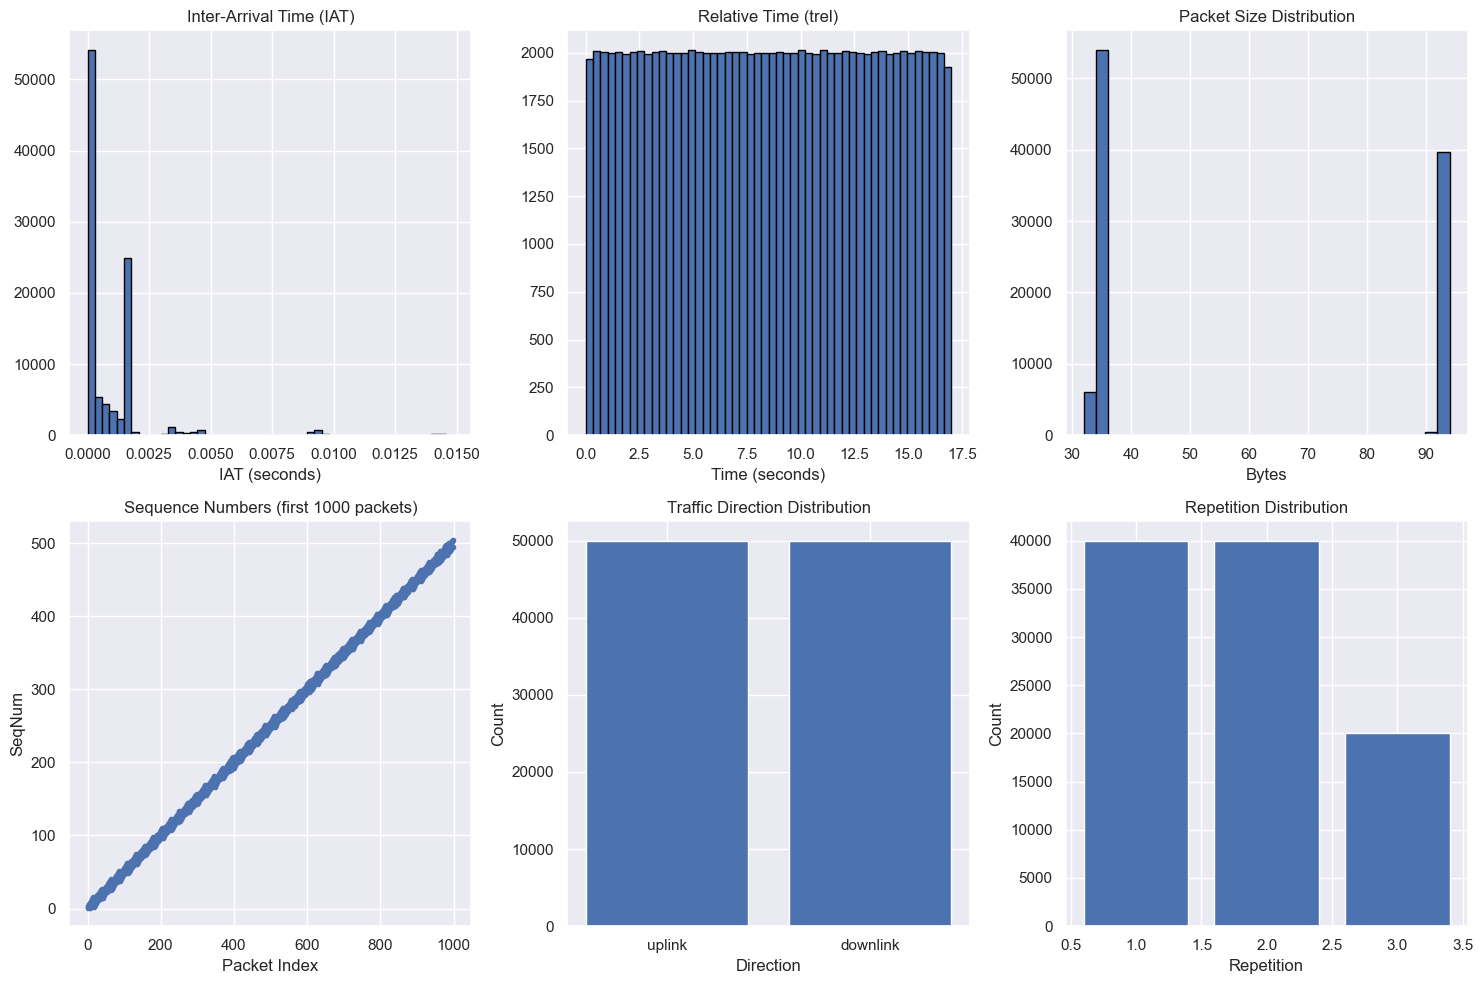

In [7]:
# Visualize distributions of key variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Inter-arrival time
axes[0, 0].hist(df_sample['iat'], bins=50, edgecolor='black')
axes[0, 0].set_title('Inter-Arrival Time (IAT)')
axes[0, 0].set_xlabel('IAT (seconds)')

# Relative time
axes[0, 1].hist(df_sample['trel'], bins=50, edgecolor='black')
axes[0, 1].set_title('Relative Time (trel)')
axes[0, 1].set_xlabel('Time (seconds)')

# Packet size
axes[0, 2].hist(df_sample['PacketSize'], bins=30, edgecolor='black')
axes[0, 2].set_title('Packet Size Distribution')
axes[0, 2].set_xlabel('Bytes')

# Sequence number
axes[1, 0].plot(df_sample['SeqNum'][:1000], marker='.')
axes[1, 0].set_title('Sequence Numbers (first 1000 packets)')
axes[1, 0].set_xlabel('Packet Index')
axes[1, 0].set_ylabel('SeqNum')

# Direction comparison
direction_counts = df_sample['direction'].value_counts()
axes[1, 1].bar(direction_counts.index, direction_counts.values)
axes[1, 1].set_title('Traffic Direction Distribution')
axes[1, 1].set_xlabel('Direction')
axes[1, 1].set_ylabel('Count')

# Repetition distribution
rep_counts = df_sample['rep'].value_counts().sort_index()
axes[1, 2].bar(rep_counts.index, rep_counts.values)
axes[1, 2].set_title('Repetition Distribution')
axes[1, 2].set_xlabel('Repetition')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

**Data Quality Assessment - Key Observations**

**Inter-Arrival Time (IAT)**
- Heavily concentrated near 0 seconds (deterministic packet generation)
- Very few outliers with higher IAT values
- Confirms the 'deterministic' packet distribution setting

**Relative Time (trel)**
- Linear growth from 0 to 17 seconds
- Uniform distribution indicates steady, continuous packet flow
- No major gaps or anomalies in timing

**Packet Size Distribution**
- Bimodal distribution: Two distinct packet sizes
- Small packets and larger packets observed
- Matches the 'small' packet size profile from experimental configuration

**Sequence Numbers**
- Perfect linear progression (no gaps observed)
- NO packet loss detected in this sample
- Excellent data quality indicator

**Traffic Direction**
- Perfectly balanced: 50% uplink, 50% downlink
- Equal representation enables fair performance comparison

**Repetitions**
- Rep 1 & 2: 40,000 packets each
- Rep 3: 20,000 packets (half the size)
- Unequal distribution - may need to consider this in analysis

---

**Summary**

Data Quality: Excellent - Clean timing, no missing sequences

Important Note: This sample shows ideal network conditions with no packet loss. We'll need to check the full dataset to find degradation scenarios for our QoS prediction models.narios for our QoS prediction models.

In [8]:
# Detect outliers in key QoS metrics using IQR method
print("=" * 80)
print("OUTLIER DETECTION")
print("=" * 80)

# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in key metrics
metrics_to_check = ['iat', 'trel', 'PacketSize']

for metric in metrics_to_check:
    outliers, lower, upper = detect_outliers_iqr(df_sample, metric)
    outlier_pct = (len(outliers) / len(df_sample)) * 100
    
    print(f"\n{metric}:")
    print(f"  Range: [{lower:.4f}, {upper:.4f}]")
    print(f"  Outliers: {len(outliers)} ({outlier_pct:.2f}%)")
    
    if len(outliers) > 0 and len(outliers) < 10:
        print(f"  Outlier values: {outliers[metric].values[:10]}")

OUTLIER DETECTION

iat:
  Range: [-0.0025, 0.0042]
  Outliers: 2739 (2.74%)

trel:
  Range: [-8.4973, 25.5067]
  Outliers: 0 (0.00%)

PacketSize:
  Range: [-52.0000, 180.0000]
  Outliers: 0 (0.00%)


**Outlier Detection Analysis**

We selected three key metrics for outlier detection based on their direct impact on Quality of Service:

- **Inter-Arrival Time (IAT)**: Measures timing between consecutive packets. Outliers indicate irregular packet spacing, which can signal network congestion or scheduling issues.
- **Relative Time (trel)**: Tracks packet timestamps over the session. Outliers would reveal unexpected gaps or timing anomalies in the data flow.
- **Packet Size**: Monitors packet dimensions. Outliers could indicate fragmentation issues or unusual traffic patterns that affect throughput.

We used the Interquartile Range (IQR) method to identify unusual values in these metrics. The IQR method flags values that fall outside 1.5 times the IQR from the first and third quartiles.

**Results:**

**Inter-Arrival Time (IAT)**
- Expected range: -0.0025 to 0.0042 seconds
- Outliers detected: 2,739 packets (2.74% of sample)
- Interpretation: A small percentage of packets arrived with unusual timing, which could indicate minor network variability or scheduling adjustments

**Relative Time (trel)**
- Expected range: -8.50 to 25.51 seconds
- Outliers detected: 0 (0.00%)
- Interpretation: Packet timestamps follow expected progression with no anomalies

**Packet Size**
- Expected range: -52 to 180 bytes
- Outliers detected: 0 (0.00%)
- Interpretation: All packet sizes fall within the expected small packet profile

---

**Conclusion:**

The dataset shows excellent quality with minimal outliers. The 2.74% outliers in inter-arrival time represent normal network variation rather than quality issues. No outliers in timing or packet size confirm stable experimental conditions.ion.stable experimental conditions.

In [16]:
# Check for duplicate rows
print("=" * 80)
print("DUPLICATE DETECTION")
print("=" * 80)

# Check for complete duplicates
duplicates = df_sample.duplicated()
n_duplicates = duplicates.sum()

print(f"\nTotal duplicate rows: {n_duplicates}")
print(f"Percentage: {(n_duplicates/len(df_sample))*100:.2f}%")

# Check for duplicate sequence numbers (shouldn't exist)
dup_seqnum = df_sample['SeqNum'].duplicated()
n_dup_seqnum = dup_seqnum.sum()

print(f"\nDuplicate sequence numbers: {n_dup_seqnum}")

DUPLICATE DETECTION

Total duplicate rows: 0
Percentage: 0.00%

Duplicate sequence numbers: 90000


No duplicate rows detected in the dataset, confirming data integrity. The 90,000 "duplicate" sequence numbers are expected because sequence numbering restarts independently for each experimental context (different repetitions, directions, and sources). Further analysis needed to verify this is normal behavior.

In [17]:
# Verify that "duplicates" are actually from different contexts
print("=" * 80)
print("SEQUENCE NUMBER ANALYSIS BY CONTEXT")
print("=" * 80)

# Check sequence numbers within each unique context
contexts = df_sample.groupby(['rep', 'direction', 'src'])

print("\nSequence number ranges by context:")
for (rep, direction, src), group in contexts:
    seqnum_range = f"{group['SeqNum'].min()} to {group['SeqNum'].max()}"
    unique_seqnums = group['SeqNum'].nunique()
    total_packets = len(group)
    duplicates_in_context = total_packets - unique_seqnums
    
    print(f"\nRep {rep} | {direction:8} | {src:4} → SeqNum: {seqnum_range}")
    print(f"  Total packets: {total_packets}, Unique SeqNums: {unique_seqnums}, Duplicates: {duplicates_in_context}")

SEQUENCE NUMBER ANALYSIS BY CONTEXT

Sequence number ranges by context:

Rep 1 | downlink | 1ue  → SeqNum: 1 to 10000
  Total packets: 10000, Unique SeqNums: 10000, Duplicates: 0

Rep 1 | downlink | 2gnb → SeqNum: 1 to 10000
  Total packets: 10000, Unique SeqNums: 10000, Duplicates: 0

Rep 1 | uplink   | 1ue  → SeqNum: 1 to 10000
  Total packets: 10000, Unique SeqNums: 10000, Duplicates: 0

Rep 1 | uplink   | 2gnb → SeqNum: 1 to 10000
  Total packets: 10000, Unique SeqNums: 10000, Duplicates: 0

Rep 2 | downlink | 1ue  → SeqNum: 1 to 10000
  Total packets: 10000, Unique SeqNums: 10000, Duplicates: 0

Rep 2 | downlink | 2gnb → SeqNum: 1 to 10000
  Total packets: 10000, Unique SeqNums: 10000, Duplicates: 0

Rep 2 | uplink   | 1ue  → SeqNum: 1 to 10000
  Total packets: 10000, Unique SeqNums: 10000, Duplicates: 0

Rep 2 | uplink   | 2gnb → SeqNum: 1 to 10000
  Total packets: 10000, Unique SeqNums: 10000, Duplicates: 0

Rep 3 | downlink | 1ue  → SeqNum: 1 to 10000
  Total packets: 10000, Un

Sequence numbers restart from 1 to 10,000 for each unique combination of repetition, direction, and source. Within each context, all sequence numbers are unique with zero duplicates, indicating NO packet loss or retransmission. The apparent "duplicates" from the previous check are simply identical sequence numbers used across different experimental contexts - this is correct and expected behavior in the network protocol implementation.

## 2-Modeling: 